In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def prepare_clustering_features(df):
    """
    Prepare features for clustering by aggregating user behavior.
    """
    # Aggregate data at user level
    user_features = df.groupby('user_id').agg({
        'product_id': 'count',  # Number of products reviewed
        'rating': ['mean', 'std'],  # Rating behavior
        'discounted_price': ['mean', 'std'],  # Price preference
        'discount_percentage': 'mean',  # Discount sensitivity
        'category': lambda x: len(x.unique()),  # Category diversity
    }).fillna(0)
    
    # Flatten column names
    user_features.columns = [f'{col[0]}_{col[1]}'.rstrip('_') 
                           for col in user_features.columns]
    
    return user_features

In [3]:
def perform_kmeans_clustering(features, n_clusters=5):
    """
    Perform K-means clustering and return labels.
    """
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Find optimal number of clusters using elbow method
    inertias = []
    K = range(1, min(11, len(features)))
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
    # Perform final clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    
    return labels, features_scaled

In [4]:
def perform_dbscan_clustering(features):
    """
    Perform DBSCAN clustering and return labels.
    """
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    labels = dbscan.fit_predict(features_scaled)
    
    return labels, features_scaled

In [5]:
def visualize_clusters(features_scaled, labels, method='K-means'):
    """
    Visualize clusters using PCA for dimensionality reduction.
    """
    # Apply PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features_scaled)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f'Customer Segments using {method}\n(PCA visualization)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

In [6]:
def analyze_clusters(df, user_features, labels, method='K-means'):
    """
    Analyze characteristics of each cluster.
    """
    # Add cluster labels to user features
    user_features['Cluster'] = labels
    
    # Calculate cluster profiles
    cluster_profiles = user_features.groupby('Cluster').mean()
    
    # Create heatmap of cluster characteristics
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_profiles, annot=True, cmap='YlOrRd', fmt='.2f')
    plt.title(f'Cluster Profiles using {method}')
    plt.show()
    
    return cluster_profiles

In [7]:
def main(df):
    """
    Main function to perform customer segmentation.
    """
    # Prepare features
    print("Preparing features...")
    user_features = prepare_clustering_features(df)
    
    # Perform K-means clustering
    print("\nPerforming K-means clustering...")
    kmeans_labels, kmeans_scaled = perform_kmeans_clustering(user_features)
    visualize_clusters(kmeans_scaled, kmeans_labels, 'K-means')
    kmeans_profiles = analyze_clusters(df, user_features, kmeans_labels, 'K-means')
    
    # Perform DBSCAN clustering
    print("\nPerforming DBSCAN clustering...")
    dbscan_labels, dbscan_scaled = perform_dbscan_clustering(user_features)
    visualize_clusters(dbscan_scaled, dbscan_labels, 'DBSCAN')
    dbscan_profiles = analyze_clusters(df, user_features, dbscan_labels, 'DBSCAN')
    
    return kmeans_profiles, dbscan_profiles

In [8]:
# Load DataFrame
df = pd.read_csv('/Users/anithasmac/Projects/CustomerJourneyMapping/Featured_Amazon_Data.csv')

Preparing features...

Performing K-means clustering...


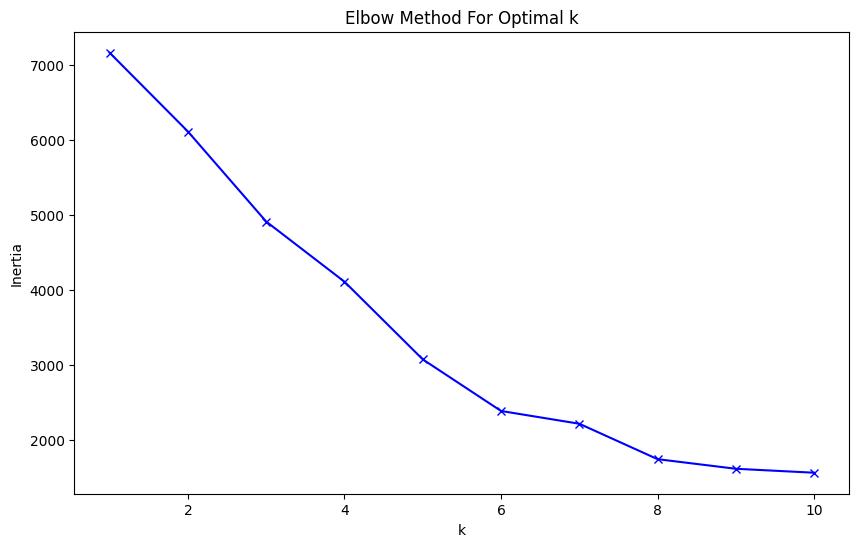

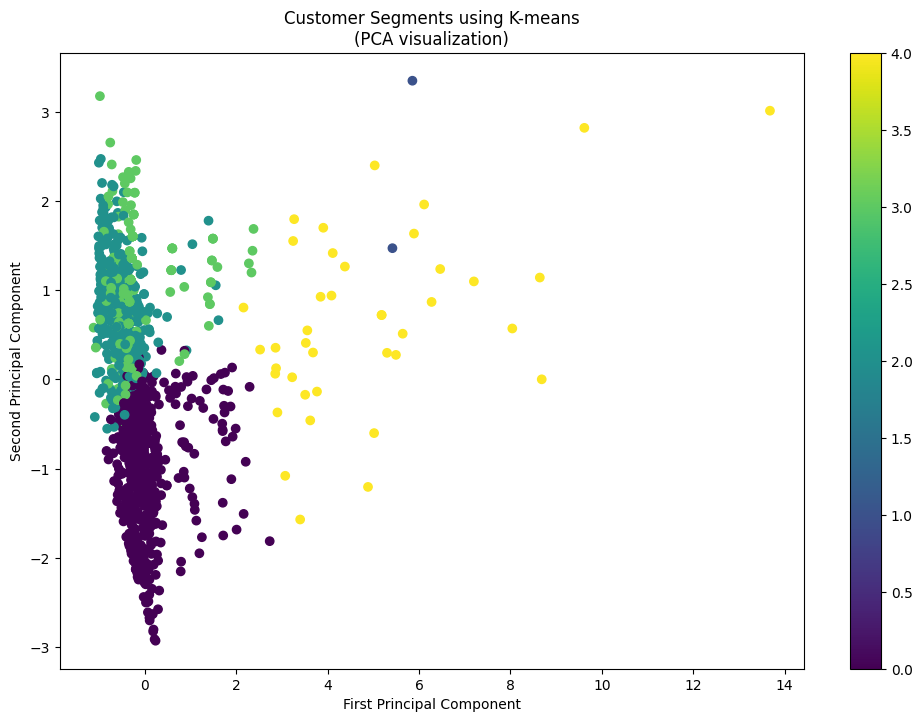

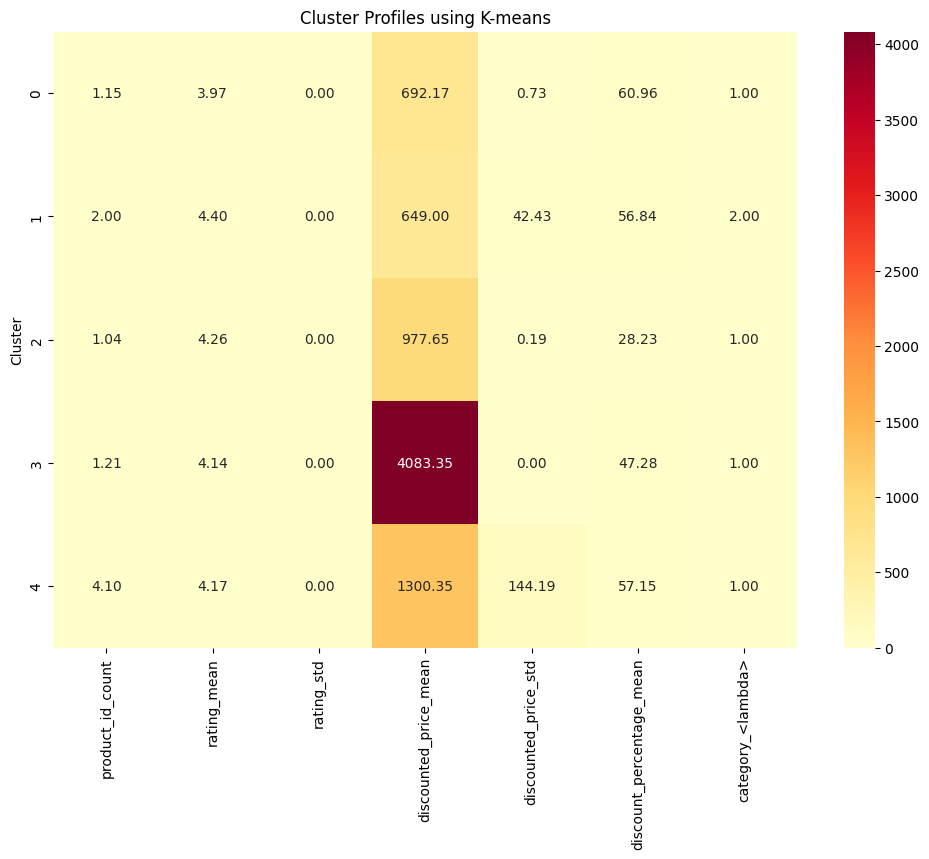


Performing DBSCAN clustering...


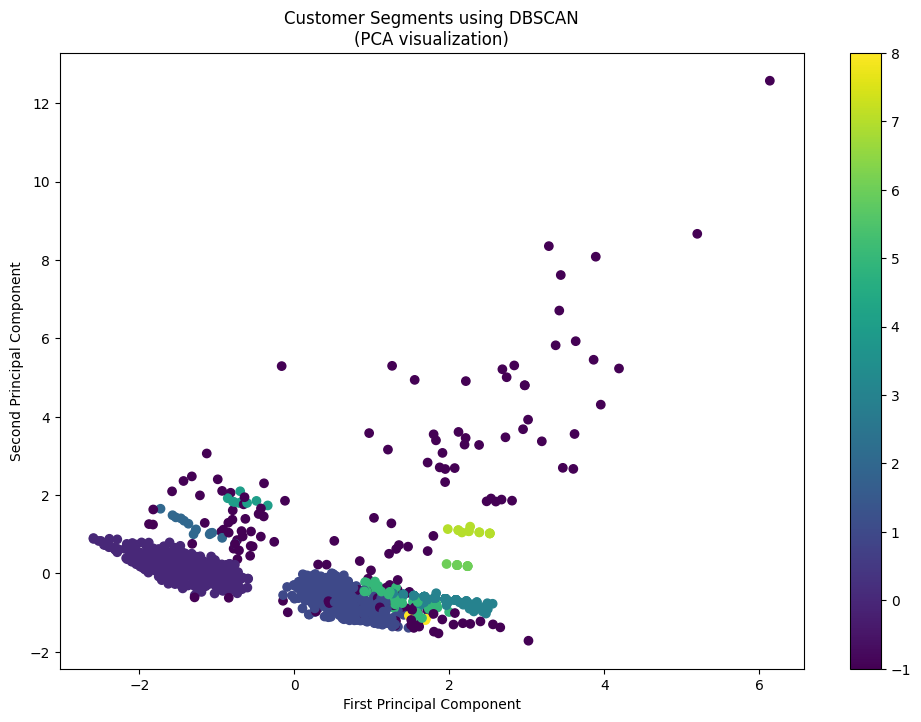

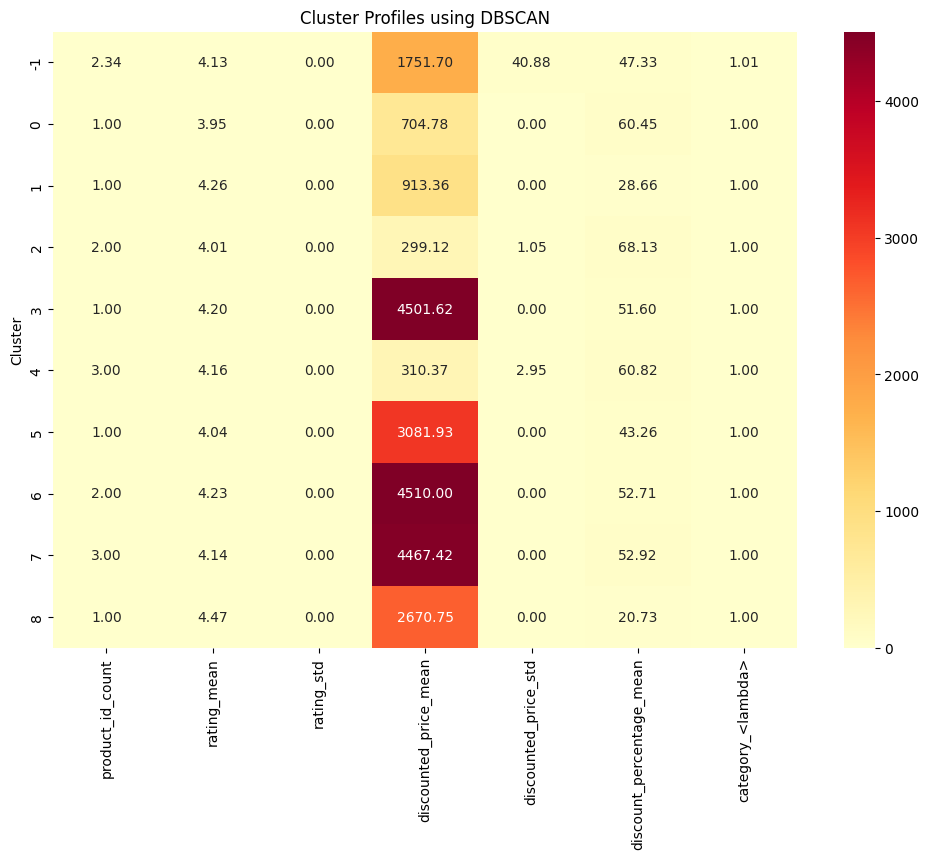


K-means Cluster Profiles:
(         product_id_count  rating_mean  rating_std  discounted_price_mean  \
Cluster                                                                     
0                1.145907     3.969573         0.0             692.172346   
1                2.000000     4.400000         0.0             649.000000   
2                1.041322     4.261433         0.0             977.652617   
3                1.211454     4.138987         0.0            4083.352863   
4                4.100000     4.165000         0.0            1300.346005   

         discounted_price_std  discount_percentage_mean  category_<lambda>  
Cluster                                                                     
0                    0.734727                 60.958205                1.0  
1                   42.426407                 56.835987                2.0  
2                    0.194795                 28.225563                1.0  
3                    0.000000                 4

In [13]:
# Run the analysis
kmeans_profiles = main(df)

# Print cluster profiles
print("\nK-means Cluster Profiles:")
print(kmeans_profiles)

print("\nDBSCAN Cluster Profiles:")
print(dbscan_profiles)

In [14]:
df.columns

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'about_product',
       'user_id', 'user_name', 'review_id', 'review_title', 'review_content',
       'img_link', 'product_link', 'brand', 'normalized_review',
       'normalized_product_name', 'normalized_about_product',
       'price_differential'],
      dtype='object')